# Imports

In [1]:
import random
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
import matplotlib
import pickle
import matplotlib.gridspec as gridspec
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from astropy import units as u
from astropy.constants import G
from astropy.cosmology import Planck15 as cosmo
pd.options.mode.chained_assignment = None
matplotlib.use('Agg')
matplotlib.rc('text',usetex=True)
matplotlib.rc('xtick',labelsize=15)
matplotlib.rc('ytick',labelsize=15)

In [2]:
%matplotlib inline

# Filepaths

The following cell defines all necessary filepaths for loading in data, arrays, etc.

In [47]:
# Fill in file paths here.
# Comments correspond to the files at 
# https://drive.google.com/drive/folders/1qjy32e_gtoafJlajz9N8v14aPLFbhX8o?usp=sharing

data2d_path = "" # 2d_data
det_f_test_2d_path = "" # det_f_test_2d: feature test set used when training 2D RF classifier 
det_l_test_2d_path = "" # det_l_test_2d: label test set used when training 2D RF classifier
det_pred_2d_path = "" # det_pred_2d: deterministic predictions using 2D RF classifier
prob_pred_2d_path = "" # prob_pred_2d: probabilistic predictions using 2D RF classifier


data3d_path = "" # 3d_data
det_f_test_path_3d = "" # det_f_test_3d: feature test set used when training 3D RF classifier
det_l_test_path_3d = "" # det_l_test_3d: label test set used when training 3D RF classifier
det_pred_path_3d = "" # det_pred_3d: deterministic predictions using 3D RF classifier
prob_pred_3d_path = "" # prob_pred_3d: probabilistic predictions using 3D RF classifier

# Functions

The following cell defines helper functions for data processing and plotting.

In [4]:
def pe1d_distance(hostval,satval,dim=1000.):
    d = satval-hostval
    d[d>dim/2] = d[d>dim/2]-dim
    d[d<-dim/2] = d[d<-dim/2]+dim
    return d

def vcirc(mass,redshift,mdef,cosmo):
    '''Calculate circular velocity in km/s for halos of mass M (Msun/h)'''
    rho_crit = cosmo.critical_density(redshift)
    if mdef[-1] == 'c':
        delta = int(mdef[:-1])
        rho = delta*rho_crit
    elif mdef[-1] == 'm':
        delta = int(mdef[:-1])
        rho = delta*rho_crit*cosmo.Om(redshift)
    else:
        raise RuntimeError("Not correct mass definition")
    v = np.sqrt(G*(np.pi*4*rho/3)**(1./3)*(mass*u.Msun/cosmo.h)**(2./3))
    a = v.to(u.km/u.s)
    return a.value

def mass_2_radius(mass,redshift,mdef,cosmo):
    '''Calculate comoving radius in Mpc/h for halos of mass M (Msun/h)'''
    rho_crit = cosmo.critical_density(redshift)
    if mdef[-1] == 'c':
        delta = int(mdef[:-1])
        rho = delta*rho_crit
    elif mdef[-1] == 'm':
        delta = int(mdef[:-1])
        rho = delta*rho_crit*cosmo.Om(redshift)
    else:
        raise RuntimeError("Not correct mass definition")
    r = ((3*mass*u.Msun/cosmo.h)/(np.pi*4*rho))**(1./3)
    a = r.to(u.Mpc)
    return a.value*cosmo.h*(1+redshift)

def vr_r_plot(data, xyz, frac = 1, title = ""):
    #xyz = [dx, dy, dz, dvx, dvy, dvz, tag]
    data['r'] = np.sqrt(data[xyz[0]]**2+data[xyz[1]]**2+data[xyz[2]]**2)
    data['vr'] = (data[xyz[3]]*data[xyz[0]] + data[xyz[4]]*data[xyz[1]] + data[xyz[5]]*data[xyz[2]])/data['r']
    
    sample_data = data.sample(frac = frac)

    plt.scatter(sample_data['r'][sample_data[xyz[6]] == 1],sample_data['vr'][sample_data[xyz[6]] == 1],c='r',s=0.5)
    plt.scatter(sample_data['r'][sample_data[xyz[6]] == 0],sample_data['vr'][sample_data[xyz[6]] == 0],c='b',s=0.5)
    plt.ylim([-3,3])
    plt.xlim([0,5])
    plt.ylabel(r'$v_{r}/\sigma_v$',fontsize=20)
    plt.xlabel(r'$r/r_{\rm 200m}$',fontsize=20)
    plt.tight_layout()
    plt.title(title, fontsize = 16)
    #blue dots orbiting, red dots infalling

def get_prob_dist(pos_array, prob_array, boundaries = [0,0]):
    if boundaries[0] == 0 and boundaries[1] == 0:
        marker = 1
    else:
        marker = 0
    left = boundaries[0] + marker*(float(np.percentile(pos_array, 2.5)))
    right = boundaries[1] + marker*(float(np.percentile(pos_array, 97.5)))
    
    position_array = pos_array #df_prob['r']
    prob_array_0 = prob_array #df_prob['0 prob']
    bins = np.linspace(left, right, 101)
    hist = []
    for i in np.arange(len(bins) - 1):
        mask = (position_array < bins[i+1]) & (position_array > bins[i])
        hist.append(sum(prob_array_0[mask]))
    
    binmid = (bins[1:]+bins[:-1])/2 #gives middle of each bin
    
    hist_normalized = hist/(sum(hist)*np.diff(bins))
    return [binmid, hist_normalized]

def real_error(dists_array, types, show_dist = False):
    dist1 = dists_array[0]
    dist2 = dists_array[1]
    real_error = dist1 - dist2
    if (show_dist):
        plt.plot(dists_array[2], real_error)
        plt.xlabel("\huge{%s}"%types[0])
        plt.title("Error")
        print("Mean error (%s): "%types[1], np.mean(abs(real_error)))
    return [dists_array[2], real_error]

def overlay_dists(dist1, dist2, label1, label2, xlabel):
    plt.plot(dist1[0], dist1[1], label = label1)
    plt.plot(dist2[0], dist2[1], label = label2)
    plt.xlabel(xlabel)
    plt.legend()
    return [dist1[1], dist2[1], dist1[0], dist2[0]]

def extract_0(lst): 
    return [item[0] for item in lst]

def extract_1(lst): 
    return [item[1] for item in lst]

def extract_2(lst): 
    return [item[2] for item in lst]

def get_prob_dist(pos_array, prob_array, boundaries = [0,0]):
    if boundaries[0] == 0 and boundaries[1] == 0:
        marker = 1
    else:
        marker = 0
    left = boundaries[0] + marker*(float(np.percentile(pos_array, 2.5)))
    right = boundaries[1] + marker*(float(np.percentile(pos_array, 97.5)))
    
    position_array = pos_array #df_prob['r']
    prob_array_0 = prob_array #df_prob['0 prob']
    bins = np.linspace(left, right, 101)
    hist = []
    for i in np.arange(len(bins) - 1):
        mask = (position_array < bins[i+1]) & (position_array > bins[i])
        hist.append(sum(prob_array_0[mask]))
    
    binmid = (bins[1:]+bins[:-1])/2 #gives middle of each bin  
    hist_normalized = hist/(sum(hist)*np.diff(bins))
    
    return [binmid, hist_normalized]

def get_dist(array, boundaries = [0,0]):
    if boundaries[0] == 0 and boundaries[1] == 0:
        marker = 1
    else:
        marker = 0
    left = boundaries[0] + marker*(float(np.percentile(array, 2.5)))
    right = boundaries[1] + marker*(float(np.percentile(array, 97.5)))
    hist, bins, _ = plt.hist(array, bins = 100, range = (left, right), density = 1)
    plt.close()
    binmid = (bins[1:]+bins[:-1])/2 #gives middle of each bin
    return [binmid, hist]

def overlay_dists(dist1, dist2, label1, label2, xlabel, show=False):
    if show:
        plt.plot(dist1[0], dist1[1], label = label1)
        plt.plot(dist2[0], dist2[1], label = label2)
        plt.xlabel(xlabel)
        plt.legend()
    return [dist1[1], dist2[1], dist1[0], dist2[0]]

def overlay_array(dist1, dist2, label1, label2, xlabel, boundaries = [0,0]):
    if boundaries[0] == 0 and boundaries[1] == 0:
        marker = 1
    else:
        marker = 0
        
    data1_left = boundaries[0] + marker*(float(np.percentile(dist1, 2.5)))
    data1_right = boundaries[1] + marker*(float(np.percentile(dist1, 97.5)))
    
    data2_left = boundaries[0] + marker*(float(np.percentile(dist2, 2.5)))
    data2_right = boundaries[1] + marker*(float(np.percentile(dist2, 97.5)))
    
    left = min(data1_left, data2_left)
    right = max(data1_right, data2_right)
    
    hist1, bin1, _ = plt.hist(dist1, bins = 100, range = (left,right), alpha = 0.5, color = 'navy', density = 1)
    hist2, bin2, _ = plt.hist(dist2, bins = 100, range = (left,right), alpha = 0.5, color = 'orange', density = 1)
    #bin_centers = 0.5*(x[1:]+x[:-1])
    #plt.plot(bin_centers,n) ## using bin_centers rather than edges
    plt.close()


    bin1mid = (bin1[1:]+bin1[:-1])/2 #gives middle of each bin
    bin2mid = (bin2[1:]+bin2[:-1])/2    
    return [hist1, hist2, bin1mid, bin2mid]

def overlay_3arrays(dist1, dist2, dist3, label1, label2, label3, xlabel, boundaries = [0,0]):
    if boundaries[0] == 0 and boundaries[1] == 0:
        marker = 1
    else:
        marker = 0
        
    data1_left = boundaries[0] + marker*(float(np.percentile(dist1, 2.5)))
    data1_right = boundaries[1] + marker*(float(np.percentile(dist1, 97.5)))
    
    data2_left = boundaries[0] + marker*(float(np.percentile(dist2, 2.5)))
    data2_right = boundaries[1] + marker*(float(np.percentile(dist2, 97.5)))
    
    data3_left = boundaries[0] + marker*(float(np.percentile(dist3, 2.5)))
    data3_right = boundaries[1] + marker*(float(np.percentile(dist3, 97.5)))
    
    left = min(data1_left, data2_left, data3_left)
    right = max(data1_right, data2_right, data3_right)
    
    hist1, bin1, _ = plt.hist(dist1, bins = 100, range = (left,right), alpha = 0.5, color = 'blue', density = 1)
    hist2, bin2, _ = plt.hist(dist2, bins = 100, range = (left,right), alpha = 0.5, color = 'darkgreen', density = 1)
    hist3, bin3, _ = plt.hist(dist3, bins = 100, range = (left, right), alpha = 0.05, color = 'red', density = 1)
    plt.close()

    bin1mid = (bin1[1:]+bin1[:-1])/2 #gives middle of each bin
    bin2mid = (bin2[1:]+bin2[:-1])/2
    bin3mid = (bin3[1:]+bin3[:-1])/2
    
    #plot binmid against hist
    plt.plot(bin1mid, hist1, label = label1, color = 'blue', linestyle = '-')
    plt.plot(bin2mid, hist2, label = label2, color = 'red', linestyle = '--')
    plt.plot(bin3mid, hist3, label = label3, color = 'darkgreen', linestyle = ':')
    plt.legend(fontsize = 16)
    plt.xlabel(xlabel)
    
    return [hist1, hist2, hist3, bin1mid, bin2mid, bin3mid]

# 3D Data

## Load Data

In [5]:
data3d = pd.read_pickle(data3d_path)
data3d = data3d[data3d['tag'] != 2]
data3d.head()

,dx,dy,dz,dvx,dvy,dvz,tag,r
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
1,-0.709824,-0.879130,-0.879130,0.149937,-0.065197,-0.011953,0.0,1.431639
2,-0.183328,-0.214666,-0.214666,-0.467612,-1.055198,-0.715008,0.0,0.354644
3,-1.972828,0.289444,0.289444,0.079216,0.001555,-0.292272,1.0,2.014846
4,-2.034809,0.326130,0.326130,-0.404284,0.318534,-0.580448,1.0,2.086425


## Load 3D Test Sets and Predictions

In [10]:
deterministic_package_3d = [pd.read_pickle(det_f_test_path_3d), pd.read_pickle(det_l_test_path_3d), np.load(det_pred_path_3d)]

f_test_det = deterministic_package_3d[0]
l_test_det = deterministic_package_3d[1]
l_pred_det = deterministic_package_3d[2]

results = pd.DataFrame ({
    'dx test': f_test_det['dx'],
    'dy test': f_test_det['dy'],
    'dz test': f_test_det['dz'],
    'dvx test': f_test_det['dvx'],
    'dvy test': f_test_det['dvy'],
    'dvz test': f_test_det['dvz'],
    'tag test': l_test_det,
    'tag pred': l_pred_det,
})

results['error'] = abs(results['tag test'] - results['tag pred'])
results['r'] = np.sqrt(results['dx test']**2+results['dy test']**2+results['dz test']**2)

In [11]:
probabilistic_predictions_3d = np.load(prob_pred_3d_path)

prob_0_3d = extract_0(probabilistic_predictions_3d)
prob_1_3d = extract_1(probabilistic_predictions_3d)
df_prob_3d = f_test_det
df_prob_3d['tag pred'] = l_pred_det
df_prob_3d['tag actual'] = l_test_det
df_prob_3d['0 prob'] = prob_0_3d
df_prob_3d['1 prob'] = prob_1_3d
df_prob_3d['r'] = np.sqrt(df_prob_3d['dx']**2+df_prob_3d['dy']**2+df_prob_3d['dz']**2)
df_prob_3d.head()

,dx,dy,dz,dvx,dvy,dvz,tag pred,tag actual,0 prob,1 prob,r
26674,1.015733,2.134497,2.134497,-0.431689,0.289291,-0.727370,1.0,1.0,0.00,1.00,3.184943
35343,-0.199420,-0.228346,-0.228346,0.092154,-0.104636,1.829267,1.0,1.0,0.45,0.55,0.379542
37231,0.589617,-4.354619,-4.354619,-0.176473,0.982793,-0.669271,1.0,1.0,0.00,1.00,6.186522
27395,-2.683479,-0.597219,-0.597219,-0.061170,-0.218932,0.460190,1.0,1.0,0.06,0.94,2.813255
4210,3.521964,2.037488,2.037488,0.077453,0.015227,0.595648,1.0,1.0,0.00,1.00,4.550488


### Figures

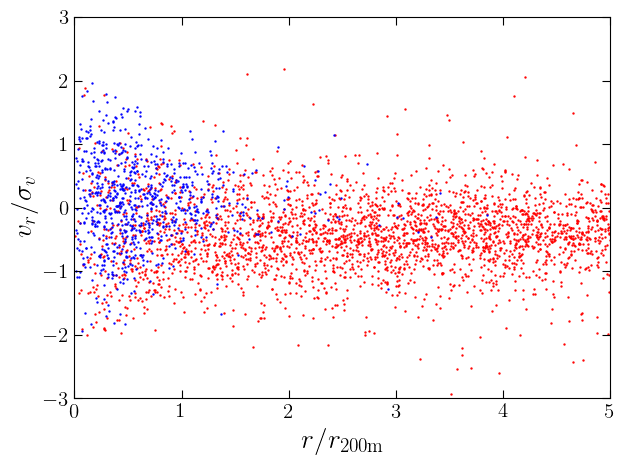

In [12]:
test_labels = ['dx test', 'dy test', 'dz test', 'dvx test', 'dvy test', 'dvz test', 'tag test']
base_labels = ['dx', 'dy', 'dz', 'dvx', 'dvy', 'dvz', 'tag']

vr_r_plot(results, test_labels, 0.01)
plt.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)

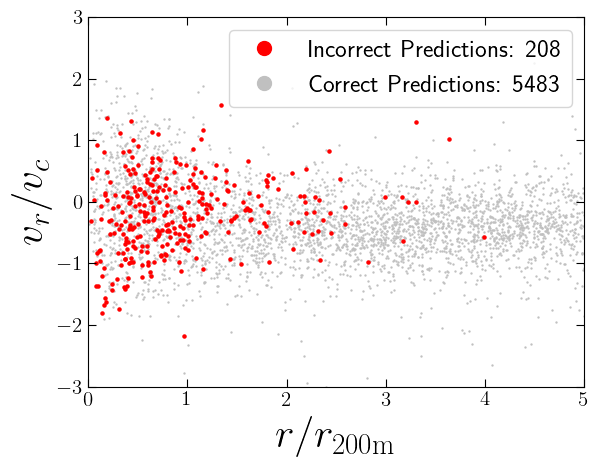

In [13]:
from matplotlib.lines import Line2D

test_labels = ['dx test', 'dy test', 'dz test', 'dvx test', 'dvy test', 'dvz test', 'tag test']
base_labels = ['dx', 'dy', 'dz', 'dvx', 'dvy', 'dvz', 'tag']

sample_data = results.sample(frac = 0.01)
xyz = test_labels
xyz.append('error')

fig = plt.figure()
gs = gridspec.GridSpec(1,1, wspace = 0.05)
ax0 = plt.subplot(gs[0])

ax0.scatter(sample_data['r'][sample_data[xyz[7]] == 1],sample_data['vr'][sample_data[xyz[7]] == 1],c='red',s=5, zorder = 1)
ax0.scatter(sample_data['r'][sample_data[xyz[7]] == 0],sample_data['vr'][sample_data[xyz[7]] == 0],c='silver',s=0.5, zorder = 0)
ax0.set_ylim([-3,3])
ax0.set_xlim([0,5])
ax0.set_ylabel(r'$v_r / v_c$', fontsize=30)
ax0.set_xlabel(r'$r/r_{\rm 200m}$',fontsize=30)

legend_elements = [Line2D([0], [0], marker='o', color='red', label='Incorrect Predictions: 208',
                          markerfacecolor='red', markersize=10, linestyle=''),
                   Line2D([0], [0], marker='o', color='silver', label='Correct Predictions: 5483',
                          markerfacecolor='silver', markersize=10, linestyle=''),
                  ]

ax0.legend(handles=legend_elements, loc='upper right', fontsize=18)

plt.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)

In [15]:
tag_0 = data3d[data3d['tag'] == 0]
tag_1 = data3d[data3d['tag'] == 1]

tag_0_r = np.sqrt(tag_0['dx']**2 + tag_0['dy']**2 + tag_0['dz']**2)
r_0_dist = get_dist(tag_0_r, [0, 5])

tag_1_r = np.sqrt(tag_1['dx']**2 + tag_1['dy']**2 + tag_1['dz']**2)
r_1_dist = get_dist(tag_1_r, [0.1 ,5])

prob_dist_0 = get_prob_dist(df_prob_3d['r'], df_prob_3d['0 prob'], [0,5]) 
prob_dist_1 = get_prob_dist(df_prob_3d['r'], df_prob_3d['1 prob'], [0.1,5])

tag_1_pred = results[results['tag pred'] == 1]
tag_0_pred = results[results['tag pred'] == 0]

In [16]:
probabilistic_r0 = overlay_dists(prob_dist_0, r_0_dist, "Predicted (Probabilistic)", "Actual", "\huge{$r_0$}")
classification_r0 = overlay_array(tag_0_pred['r'], tag_0_r, "Deterministic", "Actual", '\huge{$r/r_{200m}$}', [0,5])

classification_r1 = overlay_array(tag_1_pred['r'], tag_1_r, "Deterministic", "Actual", '\huge{$r/r_{200m}$}',[0.1,5])
probabilistic_r1 = overlay_dists(prob_dist_1, r_1_dist, "Predicted (Probabilistic)", "Actual", "\huge{$r_1$}")

In [17]:
prob_real_error_0 = real_error(probabilistic_r0, ["$r/r_{200m}$", "Probabilistic"])
class_real_error_0 = real_error(classification_r0, ["$r/r_{200m}$", "Classification"])

prob_real_error_1 = real_error(probabilistic_r1, ["$r/r_{200m}$", "Probabilistic"])
class_real_error_1 = real_error(classification_r1, ["$r/r_{200m}$", "Classification"])

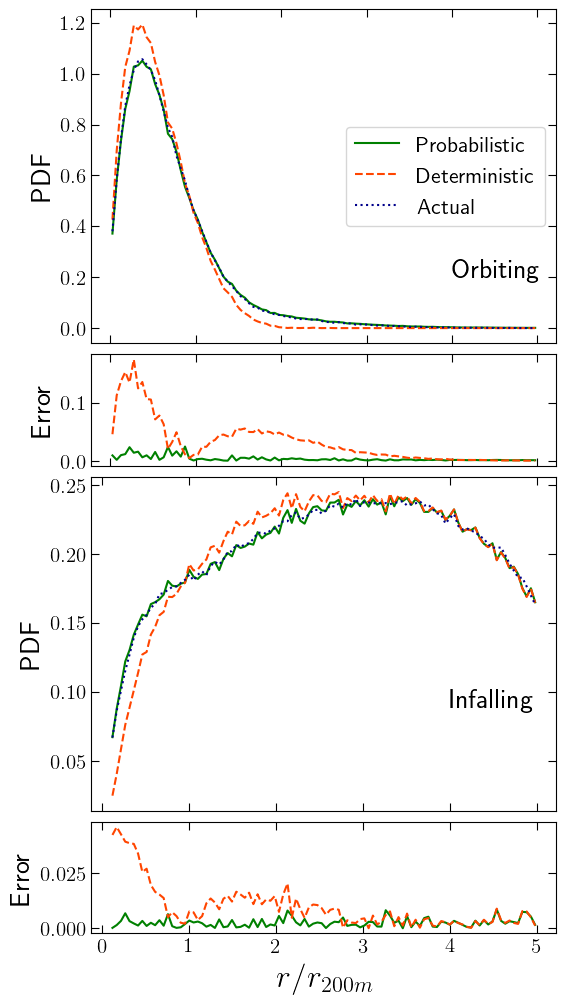

In [18]:
fig = plt.figure(figsize=(6,12))
gs = gridspec.GridSpec(4,1, height_ratios = [3,1, 3, 1], hspace = 0.05)
ax0 = plt.subplot(gs[0])
ax0.plot(prob_dist_0[0], prob_dist_0[1], label = "Probabilistic", linestyle='-', color='green')
ax0.plot(classification_r0[2], classification_r0[0], label = "Deterministic", linestyle='--', color='orangered')
ax0.plot(classification_r0[3], classification_r0[1], label = "Actual", linestyle=':', color='darkblue')
ax0.legend(fontsize = 16, loc = 'center right')
ax0.xaxis.set_ticklabels([])
ax0.set_ylabel("PDF", fontsize = 20)

ax2 = plt.subplot(gs[1])
ax2.plot(prob_real_error_0[0], abs(prob_real_error_0[1]), label = "Probabilistic", color='green')
ax2.plot(class_real_error_0[0], abs(class_real_error_0[1]), label = "Deterministic", color='orangered', linestyle='--')
ax0.tick_params(axis = 'both', direction = 'in', top = 'on')
ax2.set_xlabel("$r/r_{200m}$", fontsize = 23)
ax2.set_ylabel("Error", fontsize = 20)
ax2.xaxis.set_ticklabels([])

ax1 = plt.subplot(gs[2])
ax1.plot(prob_dist_1[0], prob_dist_1[1], label = "Probabilistic", color='green')
ax1.plot(classification_r1[2], classification_r1[0], label = "Deterministic", linestyle='--', color='orangered')
ax1.plot(classification_r1[3], classification_r1[1], label = "Actual", linestyle=':', color='darkblue')
ax1.xaxis.set_ticklabels([])
ax1.set_ylabel("PDF", fontsize = 20)

ax3 = plt.subplot(gs[3])
ax3.plot(prob_real_error_1[0], abs(prob_real_error_1[1]), label = "Probabilistic", color='green')
ax3.plot(class_real_error_1[0], abs(class_real_error_1[1]), label = "Deterministic", color='orangered', linestyle='--')
ax1.tick_params(axis = 'both', direction = 'in', top = 'on')
ax3.set_xlabel("$r/r_{200m}$", fontsize = 23)
ax3.set_ylabel("Error", fontsize = 20)

ax0.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax1.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax2.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax3.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax3.text(4,0.1, "Infalling", fontsize = 20)
ax0.text(4,0.2, "Orbiting", fontsize = 20)
plt.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)

# 2D Data

In [19]:
data2d = pd.read_pickle(data2d_path)
data2d.head()

,d2d,v,mratio,sm,ssfr,tag,id,hostid,sfr
0,0.300863,-0.416635,0.003269,7.514302e+10,-12.015534,0.0,3.000001e+16,1.042301e+10,0.072503
1,0.238698,-1.011838,0.000565,3.497926e+10,-11.663453,0.0,3.200000e+16,1.042301e+10,0.075920
2,0.134739,-1.353045,0.000820,6.465858e+10,-11.779242,0.0,2.700001e+16,1.042301e+10,0.107494
3,0.554490,-0.129616,0.001351,5.195008e+10,-11.673680,0.0,1.600001e+16,1.042301e+10,0.110130
4,0.035939,-1.101841,0.001089,3.182214e+10,-11.447515,0.0,4.500000e+16,1.042301e+10,0.113557


In [20]:
#0 = orbiting, 1 = infalling, 2 = interlopers
tag0_2d = data2d[data2d['tag'] == 0]
tag1_2d = data2d[data2d['tag'] == 1]
tag2_2d = data2d[data2d['tag'] == 2]

In [21]:
tag0_d2d_dist = get_dist(tag0_2d['d2d'], [0,5])
tag1_d2d_dist = get_dist(tag1_2d['d2d'],[0,5])
tag2_d2d_dist = get_dist(tag2_2d['d2d'],[0,5])

### sSFR Distribution Figure

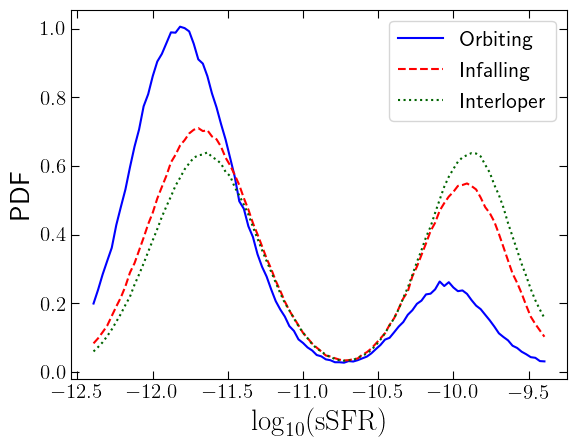

In [22]:
sfr_overlay = overlay_3arrays(tag0_2d['ssfr'], tag1_2d['ssfr'], tag2_2d['ssfr'], "Orbiting", "Infalling", "Interloper", r"\huge{$\log_{10}({\rm sSFR})$}")
plt.ylabel("PDF", fontsize=20)
plt.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)

## Load Trained RF Classifier, Test Sets, and Predictions

In [23]:
det_package_2d = [pd.read_pickle(det_f_test_2d_path), pd.read_pickle(det_l_test_2d_path), np.load(det_pred_2d_path)]

f_test2d = det_package_2d[0]
l_test2d = det_package_2d[1]
det_predictions2d = det_package_2d[2]

In [24]:
probabilistic_predictions_2d = np.load(prob_pred_2d_path)

## Results

In [25]:
results2d = pd.DataFrame ({
    'd2d test': f_test2d['d2d'],
    'v test': f_test2d['v'],
    'mratio test': f_test2d['mratio'],
    'ssfr test': f_test2d['ssfr'],
    'tag test': l_test2d,
    'tag pred': det_predictions2d,
})

results2d['error'] = abs(results2d['tag test'] - results2d['tag pred'])

results2d.head()

,d2d test,v test,mratio test,ssfr test,tag test,tag pred,error
8653,4.655444,-1.449196,0.001386,-11.227659,2.0,2.0,0.0
2642,4.322706,-0.433429,0.009329,-11.428984,2.0,2.0,0.0
87659,1.740735,-3.057535,0.004870,-11.829482,2.0,2.0,0.0
89171,4.465134,0.601007,0.009278,-11.981038,2.0,2.0,0.0
35245,2.305029,-0.261067,0.007402,-11.132963,1.0,1.0,0.0


In [26]:
tag_0_pred_2d = results2d[results2d['tag pred'] == 0]
tag_1_pred_2d = results2d[results2d['tag pred'] == 1]
tag_2_pred_2d = results2d[results2d['tag pred'] == 2]

prob_0_2d = extract_0(probabilistic_predictions_2d)
prob_1_2d = extract_1(probabilistic_predictions_2d)
prob_2_2d = extract_2(probabilistic_predictions_2d)
df_prob_2d = f_test2d
df_prob_2d['tag pred'] = det_predictions2d
df_prob_2d['tag actual'] = l_test2d
df_prob_2d['0 prob'] = prob_0_2d
df_prob_2d['1 prob'] = prob_1_2d
df_prob_2d['2 prob'] = prob_2_2d

In [27]:
# orbiting population
prob_dist_0_2d = get_prob_dist(df_prob_2d['d2d'], df_prob_2d['0 prob'], [0,5])
# infallin population
prob_dist_1_2d = get_prob_dist(df_prob_2d['d2d'], df_prob_2d['1 prob'], [0,5])
# interloper population
prob_dist_2_2d = get_prob_dist(df_prob_2d['d2d'], df_prob_2d['2 prob'], [0,5])

### Orbiting

In [28]:
deterministic_r0_2d = overlay_array(tag_0_pred_2d['d2d test'], tag0_2d['d2d'], "Deterministic", "Actual", '\huge{$R/r_{200m}$}', boundaries = [0,5])
# probabilistic vs actual dists for orbiting
probabilistic_r0_2d = overlay_dists(prob_dist_0_2d, tag0_d2d_dist, "Predicted (Probabilistic)", "Actual", "\huge{$r_0$}")

In [29]:
# error for probabilistic/deterministic vs actual dists for orbiting
prob_real_error_0_2d = real_error(probabilistic_r0_2d, ["$R/r_{200m}$", "Probabilistic"])
det_real_error_0_2d = real_error(deterministic_r0_2d, ["$R/r_{200m}$", "Classification"])

Text(1.5, 0.6, 'Orbiting')

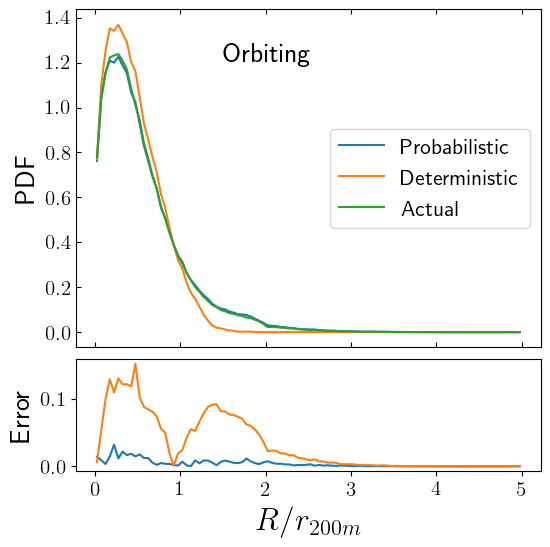

In [30]:
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(2,1, height_ratios = [3,1], hspace = 0.05)
ax0 = plt.subplot(gs[0])
ax0.plot(probabilistic_r0_2d[2], probabilistic_r0_2d[0], label = "Probabilistic")
ax0.plot(deterministic_r0_2d[2], deterministic_r0_2d[0], label = "Deterministic")
ax0.plot(deterministic_r0_2d[3], deterministic_r0_2d[1], label = "Actual")
ax0.legend(fontsize = 16, loc = "center right")
ax0.xaxis.set_ticklabels([])
ax1 = plt.subplot(gs[1])
ax1.plot(prob_real_error_0_2d[0], abs(prob_real_error_0_2d[1]), label = "Probabilistic")
ax1.plot(det_real_error_0_2d[0], abs(det_real_error_0_2d[1]), label = "Deterministic")
ax0.tick_params(axis = 'both', direction = 'in', top = 'on')
ax1.set_xlabel("$R/r_{200m}$", fontsize = 23)
ax1.set_ylabel("Error", fontsize = 20)
ax0.set_ylabel("PDF", fontsize = 20)
plt.text(1.5,0.6, "Orbiting", fontsize = 20)

### Infalling

In [31]:
deterministic_r1_2d = overlay_array(tag_1_pred_2d['d2d test'], tag1_2d['d2d'], "Deterministic", "Actual", '\huge{$R/r_{200m}$}', boundaries = [0,5])
# probabilistic vs actual dists for infalling
probabilistic_r1_2d = overlay_dists(prob_dist_1_2d, tag1_d2d_dist, "Predicted (Probabilistic)", "Actual", "\huge{$d2d_1$}")

In [32]:
# error for probabilistic/deterministic vs actual dists for infalling
prob_real_error_1_2d = real_error(probabilistic_r1_2d, ["$R/r_{200m}$", "Probabilistic"])
det_real_error_1_2d = real_error(deterministic_r1_2d, ["$R/r_{200m}$", "Classification"])

Text(4, 0.53, 'Infalling')

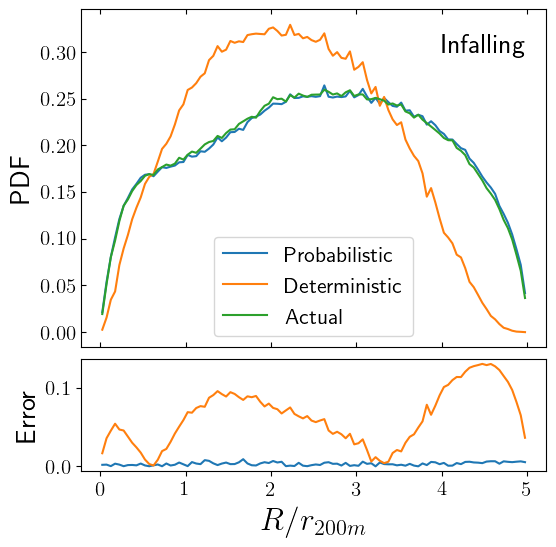

In [33]:
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(2,1, height_ratios = [3,1], hspace = 0.05)
ax0 = plt.subplot(gs[0])
ax0.plot(probabilistic_r1_2d[2], probabilistic_r1_2d[0], label = "Probabilistic")
ax0.plot(deterministic_r1_2d[2], deterministic_r1_2d[0], label = "Deterministic")
ax0.plot(deterministic_r1_2d[3], deterministic_r1_2d[1], label = "Actual")
ax0.legend(fontsize = 16)
ax0.xaxis.set_ticklabels([])
ax1 = plt.subplot(gs[1])
ax1.plot(prob_real_error_1_2d[0], abs(prob_real_error_1_2d[1]), label = "Probabilistic")
ax1.plot(det_real_error_1_2d[0], abs(det_real_error_1_2d[1]), label = "Deterministic")
ax0.tick_params(axis = 'both', direction = 'in', top = 'on')
ax1.set_xlabel("$R/r_{200m}$", fontsize = 23)
ax1.set_ylabel("Error", fontsize = 20)
ax0.set_ylabel("PDF", fontsize = 20)
plt.text(4,0.53, "Infalling", fontsize = 20)

### Interloper

In [34]:
deterministic_r2_2d = overlay_array(tag_2_pred_2d['d2d test'], tag2_2d['d2d'], "Deterministic", "Actual", '\huge{$R/r_{200m}$}', boundaries = [0,5])
probabilistic_r2_2d = overlay_dists(prob_dist_2_2d, tag2_d2d_dist, "Predicted (Probabilistic)", "Actual", "\huge{$d2d_2$}")

In [35]:
prob_real_error_2_2d = real_error(probabilistic_r2_2d, ["$R/r_{200m}$", "Probabilistic"])
det_real_error_2_2d = real_error(deterministic_r2_2d, ["$R/r_{200m}$", "Classification"])

Text(3, 0.15, 'Interloper')

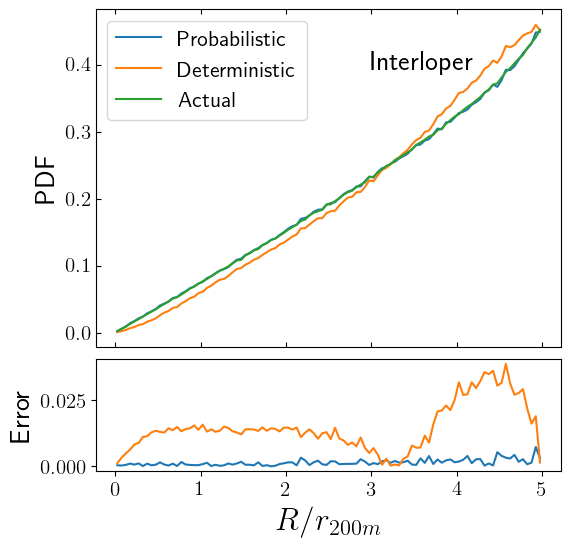

In [36]:
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(2,1, height_ratios = [3,1], hspace = 0.05)
ax0 = plt.subplot(gs[0])
ax0.plot(probabilistic_r2_2d[2], probabilistic_r2_2d[0], label = "Probabilistic")
ax0.plot(deterministic_r2_2d[2], deterministic_r2_2d[0], label = "Deterministic")
ax0.plot(deterministic_r2_2d[3], deterministic_r2_2d[1], label = "Actual")
ax0.legend(fontsize = 16)
ax0.xaxis.set_ticklabels([])
ax1 = plt.subplot(gs[1])
ax1.plot(prob_real_error_2_2d[0], abs(prob_real_error_2_2d[1]), label = "Probabilistic")
ax1.plot(det_real_error_2_2d[0], abs(det_real_error_2_2d[1]), label = "Deterministic")
ax0.tick_params(axis = 'both', direction = 'in', top = 'on')
ax1.set_xlabel("$R/r_{200m}$", fontsize = 23)
ax1.set_ylabel("Error", fontsize = 20)
ax0.set_ylabel("PDF", fontsize = 20)
plt.text(3,0.15, "Interloper", fontsize = 20)

### Combined Figure

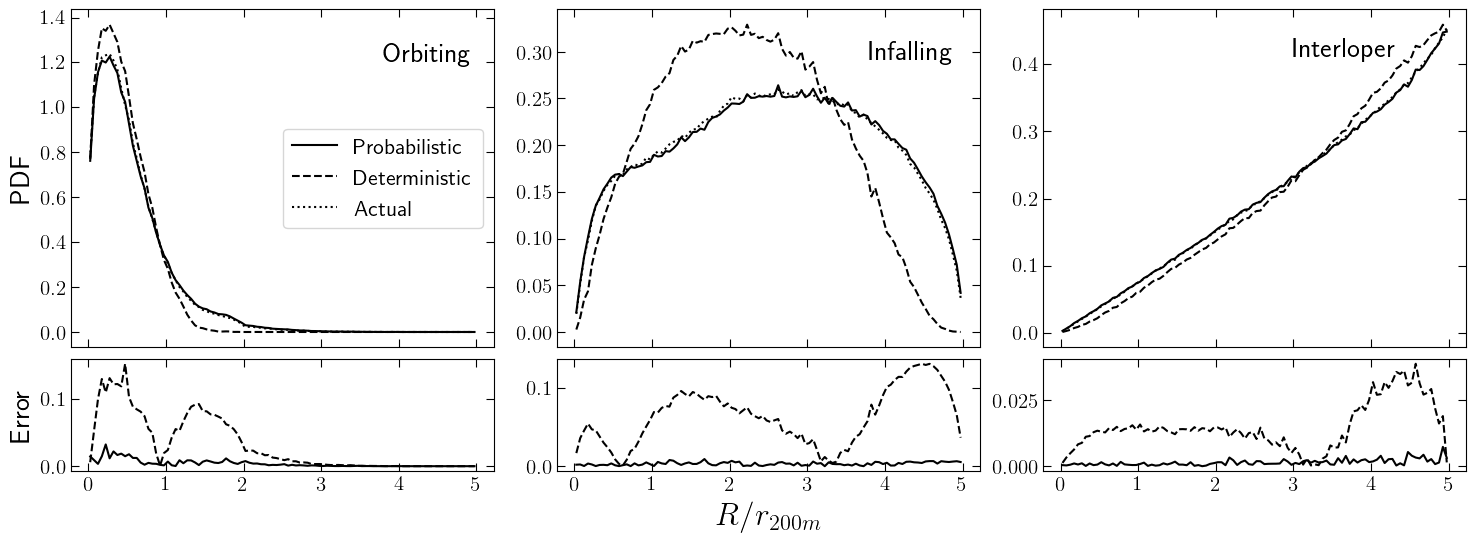

In [39]:
fig = plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(2,3, height_ratios = [3,1], hspace = 0.05, wspace = 0.15)

ax0 = plt.subplot(gs[0])
ax0.plot(probabilistic_r0_2d[2], probabilistic_r0_2d[0], label = "Probabilistic", linestyle = '-', color='black')
ax0.plot(deterministic_r0_2d[2], deterministic_r0_2d[0], label = "Deterministic", linestyle = '--', color='black')
ax0.plot(deterministic_r0_2d[3], deterministic_r0_2d[1], label = "Actual", linestyle = ':', color='black')
ax0.legend(fontsize = 16, loc = "center right")
ax0.xaxis.set_ticklabels([])

ax1 = plt.subplot(gs[3])
ax1.plot(prob_real_error_0_2d[0], abs(prob_real_error_0_2d[1]), label = "Probabilistic", linestyle = '-', color='black')
ax1.plot(det_real_error_0_2d[0], abs(det_real_error_0_2d[1]), label = "Deterministic", linestyle = '--', color='black')
ax0.tick_params(axis = 'both', direction = 'in', top = 'on')
ax1.set_ylabel("Error", fontsize = 20)
ax0.set_ylabel("PDF", fontsize = 20)
plt.text(3.8,0.6, "Orbiting", fontsize = 20)

ax2 = plt.subplot(gs[1])
ax2.plot(probabilistic_r1_2d[2], probabilistic_r1_2d[0], label = "Probabilistic", linestyle = '-', color='black')
ax2.plot(deterministic_r1_2d[2], deterministic_r1_2d[0], label = "Deterministic", linestyle = '--', color='black')
ax2.plot(deterministic_r1_2d[3], deterministic_r1_2d[1], label = "Actual", linestyle = ':', color='black')
ax2.xaxis.set_ticklabels([])

ax3 = plt.subplot(gs[4])
ax3.plot(prob_real_error_1_2d[0], abs(prob_real_error_1_2d[1]), label = "Probabilistic", linestyle = '-', color='black')
ax3.plot(det_real_error_1_2d[0], abs(det_real_error_1_2d[1]), label = "Deterministic", linestyle = '--', color='black')
ax2.tick_params(axis = 'both', direction = 'in', top = 'on')
ax3.set_xlabel("$R/r_{200m}$", fontsize = 23)
plt.text(3.8,0.52, "Infalling", fontsize = 20)

ax4 = plt.subplot(gs[2])
ax4.plot(probabilistic_r2_2d[2], probabilistic_r2_2d[0], label = "Probabilistic", linestyle = '-', color='black')
ax4.plot(deterministic_r2_2d[2], deterministic_r2_2d[0], label = "Deterministic", linestyle = '--', color='black')
ax4.plot(deterministic_r2_2d[3], deterministic_r2_2d[1], label = "Actual", linestyle = ':', color='black')
ax4.xaxis.set_ticklabels([])

ax5 = plt.subplot(gs[5])
ax5.plot(prob_real_error_2_2d[0], abs(prob_real_error_2_2d[1]), label = "Probabilistic", linestyle = '-', color='black')
ax5.plot(det_real_error_2_2d[0], abs(det_real_error_2_2d[1]), label = "Deterministic", linestyle = '--', color='black')
ax4.tick_params(axis = 'both', direction = 'in', top = 'on')

plt.text(3,0.155, "Interloper", fontsize = 20)
ax0.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax1.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax2.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax3.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax4.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax5.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)

# Correct/Incorrect Predictions Figure for 3D/2D

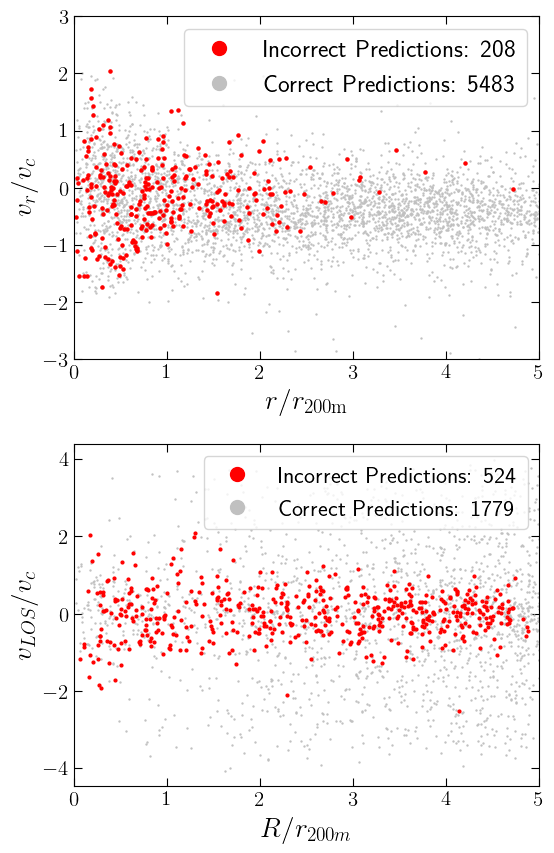

In [75]:
fig = plt.figure(figsize=(6,10))
gs = gridspec.GridSpec(2,1, hspace = 0.25)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.scatter(sample_data['r'][sample_data[xyz[7]] == 1],sample_data['vr'][sample_data[xyz[7]] == 1],c='red',s=5, zorder = 1)
ax0.scatter(sample_data['r'][sample_data[xyz[7]] == 0],sample_data['vr'][sample_data[xyz[7]] == 0],c='silver',s=0.5, zorder = 0)
ax0.set_ylim([-3,3])
ax0.set_xlim([0,5])
ax0.set_ylabel(r'$v_r / v_c$', fontsize=20)
ax0.set_xlabel(r'$r/r_{\rm 200m}$',fontsize=20)

legend_elements0 = [Line2D([0], [0], marker='o', color='red', label='Incorrect Predictions: 208',
                          markerfacecolor='red', markersize=10, linestyle=''),
                   Line2D([0], [0], marker='o', color='silver', label='Correct Predictions: 5483',
                          markerfacecolor='silver', markersize=10, linestyle=''),
                  ]

ax0.legend(handles=legend_elements0, loc='upper right', fontsize=18)
ax0.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)

sample_data2d = results2d.sample(frac = 0.0015)
groups = sample_data2d.groupby('error')
num_correct = 0
num_incorrect = 0
for name, group in groups:
    if name != 0: # incorrect
        color = 'red'
        num_incorrect = num_incorrect + len(group)
    else: # correct
        color = 'silver'
        num_correct = num_correct + len(group)
    if color == 'red':
        markersize = 2
    else:
        markersize = 0.7
    ax1.plot(group['d2d test'], group['v test'], marker='o', linestyle='', markersize=markersize, label=name, color = color)

    
ax1.set_ylabel(r'$v_{LOS}/v_c$', fontsize=20)
ax1.set_xlabel('${R/r_{200m}}$', fontsize=20)
ax1.set_xlim([0,5])

legend_elements1 = [Line2D([0], [0], marker='o', color='red', label=f'Incorrect Predictions: {num_incorrect}',
                          markerfacecolor='red', markersize=10, linestyle=''),
                  Line2D([0], [0], marker='o', color='silver', label=f'Correct Predictions: {num_correct}',
                          markerfacecolor='silver', markersize=10, linestyle='')]
ax1.legend(handles = legend_elements1, fontsize = 17, loc = 'upper right')
ax1.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)


# Distribution Match for V_los

### Orbiting

In [40]:
data2d_orbiting = data2d[data2d['tag'] == 0]
orbiting_vlos = get_dist(data2d_orbiting['v'], boundaries=[-2, 2])

orbiting_det_vlos = get_dist(results2d[results2d['tag pred'] == 0]['v test'], boundaries = [-2, 2])
orbiting_prob_vlos = get_prob_dist(results2d['v test'], df_prob_2d['0 prob'], boundaries=[-2,2])
prob_vs_actual_vlos_orbiting = overlay_dists(orbiting_vlos, orbiting_prob_vlos, "Actual", "Probabilistic", "")

Text(1, 0.1, 'Orbiting')

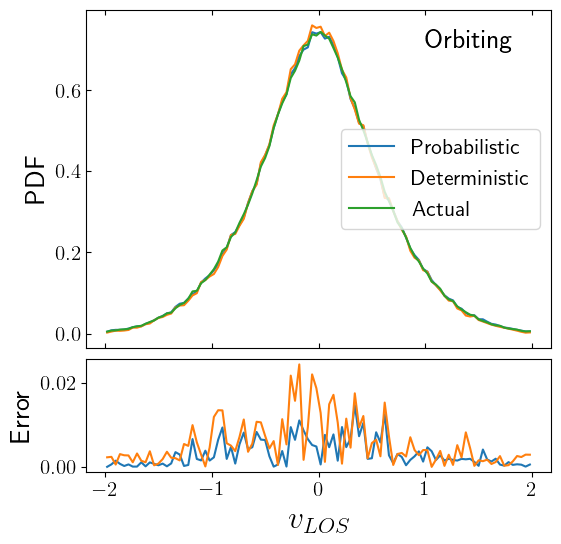

In [41]:
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(2,1, height_ratios = [3,1], hspace = 0.05)
ax0 = plt.subplot(gs[0])
ax0.plot(orbiting_prob_vlos[0], orbiting_prob_vlos[1], label = "Probabilistic")
ax0.plot(orbiting_det_vlos[0], orbiting_det_vlos[1], label = "Deterministic")
ax0.plot(orbiting_vlos[0], orbiting_vlos[1], label = "Actual")
ax0.legend(fontsize = 16, loc = "center right")
ax0.xaxis.set_ticklabels([])

ax1 = plt.subplot(gs[1])
ax1.plot(orbiting_prob_vlos[0],abs(orbiting_prob_vlos[1]-orbiting_vlos[1]), label = "Probabilistic")
ax1.plot(orbiting_prob_vlos[0], abs(orbiting_det_vlos[1]-orbiting_vlos[1]), label = "Deterministic")
ax0.tick_params(axis = 'both', direction = 'in', top = 'on')
ax1.set_xlabel("$v_{LOS}$", fontsize = 23)
ax1.set_ylabel("Error", fontsize = 20)
ax0.set_ylabel("PDF", fontsize = 20)
plt.text(1,0.1, "Orbiting", fontsize = 20)

### Infalling

In [42]:
data2d_infalling = data2d[data2d['tag'] == 1]
infalling_vlos = get_dist(data2d_infalling['v'], boundaries=[-2, 2])

In [43]:
infalling_det_vlos = get_dist(results2d[results2d['tag pred'] == 1]['v test'], boundaries = [-2, 2])
infalling_prob_vlos = get_prob_dist(results2d['v test'], df_prob_2d['1 prob'], boundaries=[-2,2])
prob_vs_actual_vlos_infalling = overlay_dists(infalling_vlos, infalling_prob_vlos, "Actual", "Probabilistic", "V")

Text(1, 0.9, 'Infalling')

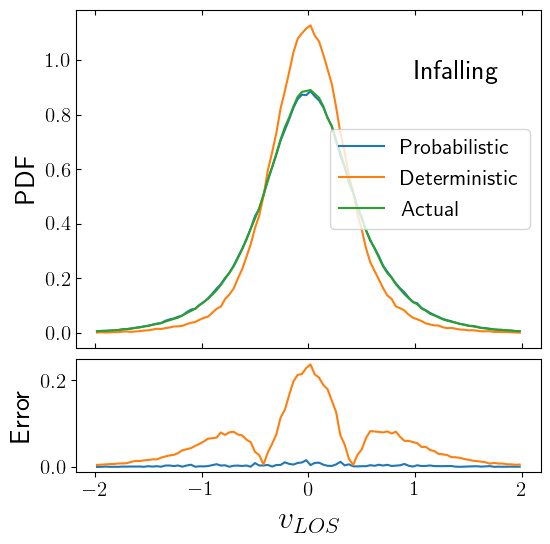

In [44]:
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(2,1, height_ratios = [3,1], hspace = 0.05)
ax0 = plt.subplot(gs[0])
ax0.plot(infalling_prob_vlos[0], infalling_prob_vlos[1], label = "Probabilistic")
ax0.plot(infalling_det_vlos[0], infalling_det_vlos[1], label = "Deterministic")
ax0.plot(infalling_vlos[0], infalling_vlos[1], label = "Actual")
ax0.legend(fontsize = 16, loc = "center right")
ax0.xaxis.set_ticklabels([])

ax1 = plt.subplot(gs[1])
ax1.plot(infalling_prob_vlos[0],abs(infalling_prob_vlos[1]-infalling_vlos[1]), label = "Probabilistic")
ax1.plot(infalling_prob_vlos[0], abs(infalling_det_vlos[1]-infalling_vlos[1]), label = "Deterministic")
ax0.tick_params(axis = 'both', direction = 'in', top = 'on')
ax1.set_xlabel("$v_{LOS}$", fontsize = 23)
ax1.set_ylabel("Error", fontsize = 20)
ax0.set_ylabel("PDF", fontsize = 20)
plt.text(1,0.9, "Infalling", fontsize = 20)

### Combined Figure

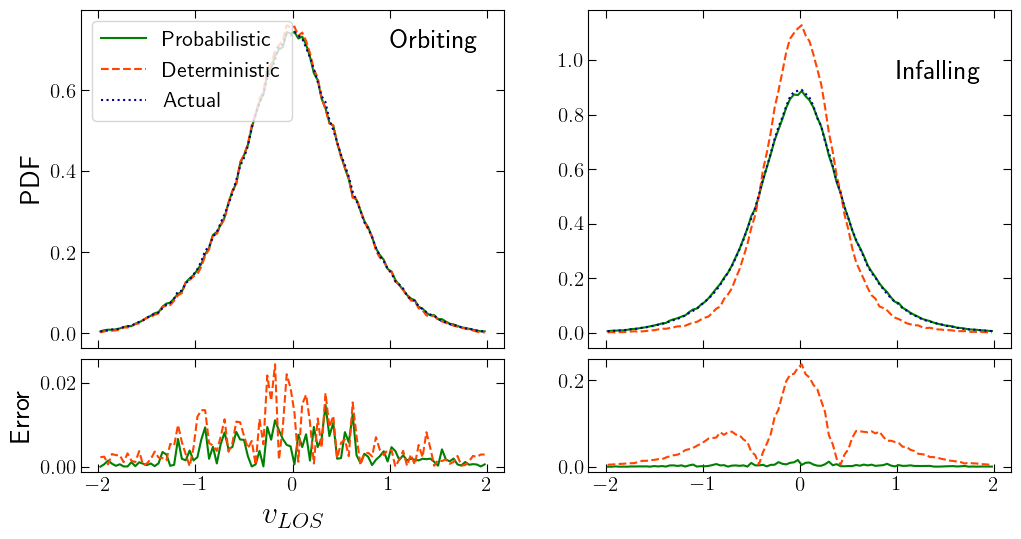

In [46]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2,2, height_ratios = [3,1], hspace = 0.05)

ax0 = plt.subplot(gs[0])
ax0.plot(orbiting_prob_vlos[0], orbiting_prob_vlos[1], label = "Probabilistic", linestyle = '-', color='green')
ax0.plot(orbiting_det_vlos[0], orbiting_det_vlos[1], label = "Deterministic", linestyle = '--', color='orangered')
ax0.plot(orbiting_vlos[0], orbiting_vlos[1], label = "Actual", linestyle = ':', color='darkblue')
ax0.legend(fontsize = 16, loc = "upper left")
ax0.xaxis.set_ticklabels([])

ax1 = plt.subplot(gs[2])
ax1.plot(orbiting_prob_vlos[0],abs(orbiting_prob_vlos[1]-orbiting_vlos[1]), label = "Probabilistic", linestyle = '-', color='green')
ax1.plot(orbiting_prob_vlos[0], abs(orbiting_det_vlos[1]-orbiting_vlos[1]), label = "Deterministic", linestyle = '--', color='orangered')
ax0.tick_params(axis = 'both', direction = 'in', top = 'on')
ax1.set_xlabel("$v_{LOS}$", fontsize = 23)
ax1.set_ylabel("Error", fontsize = 20)
ax0.set_ylabel("PDF", fontsize = 20)
plt.text(1,0.1, "Orbiting", fontsize = 20)

ax2 = plt.subplot(gs[1])
ax2.plot(infalling_prob_vlos[0], infalling_prob_vlos[1], label = "Probabilistic", linestyle = '-', color='green')
ax2.plot(infalling_det_vlos[0], infalling_det_vlos[1], label = "Deterministic", linestyle = '--', color='orangered')
ax2.plot(infalling_vlos[0], infalling_vlos[1], label = "Actual", linestyle = ':', color='darkblue')
ax2.xaxis.set_ticklabels([])

ax3 = plt.subplot(gs[3])
ax3.plot(infalling_prob_vlos[0],abs(infalling_prob_vlos[1]-infalling_vlos[1]), label = "Probabilistic", linestyle = '-', color='green')
ax3.plot(infalling_prob_vlos[0], abs(infalling_det_vlos[1]-infalling_vlos[1]), label = "Deterministic", linestyle = '--', color='orangered')
ax2.tick_params(axis = 'both', direction = 'in', top = 'on')
ax1.set_xlabel("$v_{LOS}$", fontsize = 23)
ax1.set_ylabel("Error", fontsize = 20)
ax0.set_ylabel("PDF", fontsize = 20)
plt.text(1,0.9, "Infalling", fontsize = 20)

ax0.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax1.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax2.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax3.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)

# Combined vr (3D and 2D) Figure

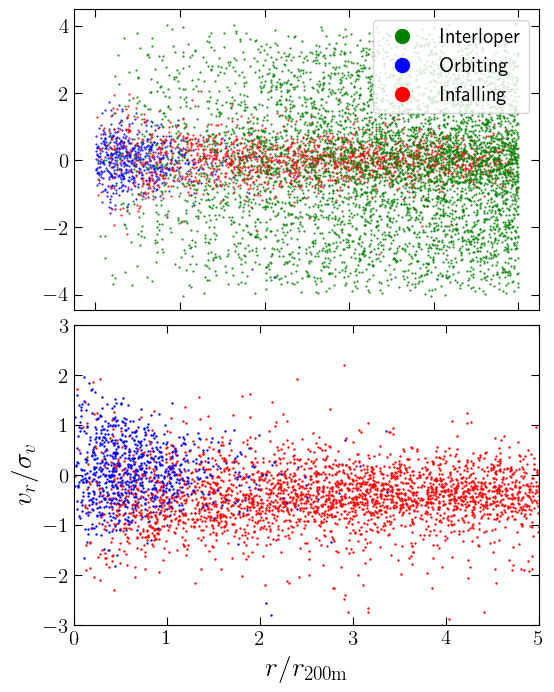

In [85]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(6,8))
gs = gridspec.GridSpec(2,1, hspace = 0.05)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

sample_data2d = data2d.sample(frac = 0.0015)
colors = ['blue', 'red', 'green']
groups = sample_data2d.groupby('tag')
i = 0
for name, group in groups:
    ax0.plot(group['d2d'], group['v'], marker='o', linestyle='', markersize=0.5, label=name, color = colors[i])
    i+=1

ax0.xaxis.set_ticklabels([])

test_labels = ['dx test', 'dy test', 'dz test', 'dvx test', 'dvy test', 'dvz test', 'tag test']
base_labels = ['dx', 'dy', 'dz', 'dvx', 'dvy', 'dvz', 'tag']

ax1.plot()


data = results
data['r'] = np.sqrt(data[xyz[0]]**2+data[xyz[1]]**2+data[xyz[2]]**2)
data['vr'] = (data[xyz[3]]*data[xyz[0]] + data[xyz[4]]*data[xyz[1]] + data[xyz[5]]*data[xyz[2]])/data['r']
sample_data = data.sample(frac = 0.01)

ax1.scatter(sample_data['r'][sample_data[xyz[6]] == 1],sample_data['vr'][sample_data[xyz[6]] == 1],c='r',s=0.5)
ax1.scatter(sample_data['r'][sample_data[xyz[6]] == 0],sample_data['vr'][sample_data[xyz[6]] == 0],c='b',s=0.5)
ax1.set_ylim([-3,3])
ax1.set_xlim([0,5])
ax1.set_ylabel(r'$v_{r}/\sigma_v$',fontsize=20)
ax1.set_xlabel(r'$r/r_{\rm 200m}$',fontsize=20)

ax0.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax1.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)

legend_elements = [Line2D([0], [0], marker='o', color='green', label='Interloper',
                          markerfacecolor='green', markersize=10, linestyle=''),
                   Line2D([0], [0], marker='o', color='blue', label='Orbiting',
                          markerfacecolor='blue', markersize=10, linestyle=''),
                   Line2D([0], [0], marker='o', color='red', label='Infalling',
                          markerfacecolor='red', markersize=10, linestyle=''),]
ax0.legend(handles = legend_elements, fontsize = 15, loc = 'upper right')

# Combined VR Plots

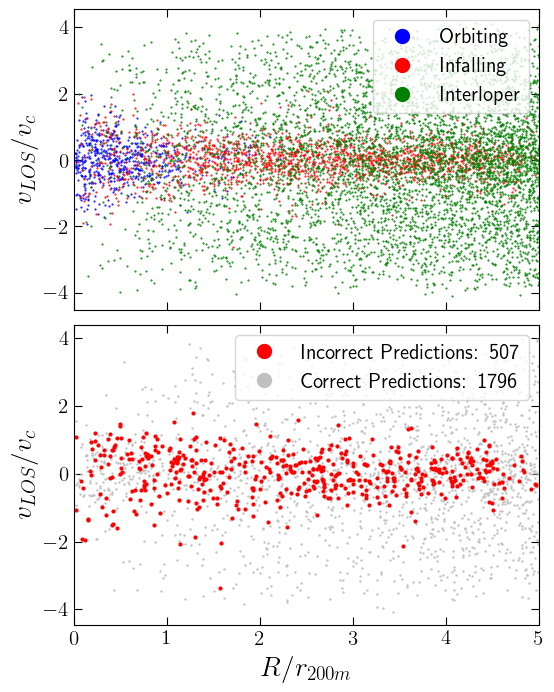

In [86]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(6,8))
gs = gridspec.GridSpec(2,1, hspace = 0.05)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

sample_data2d = data2d.sample(frac = 0.0015)
colors = ['blue', 'red', 'green']
groups = sample_data2d.groupby('tag')
i = 0
for name, group in groups:
    ax0.plot(group['d2d'], group['v'], marker='o', linestyle='', markersize=0.5, label=name, color = colors[i])
    i+=1

ax0.xaxis.set_ticklabels([])

test_labels = ['dx test', 'dy test', 'dz test', 'dvx test', 'dvy test', 'dvz test', 'tag test']
base_labels = ['dx', 'dy', 'dz', 'dvx', 'dvy', 'dvz', 'tag']

ax1.plot()

ax0.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax1.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)

legend_elements = [Line2D([0], [0], marker='o', color='blue', label='Orbiting',
                          markerfacecolor='blue', markersize=10, linestyle=''),
                   Line2D([0], [0], marker='o', color='red', label='Infalling',
                          markerfacecolor='red', markersize=10, linestyle=''),
                   Line2D([0], [0], marker='o', color='green', label='Interloper',
                          markerfacecolor='green', markersize=10, linestyle=''),]
ax0.legend(handles = legend_elements, fontsize = 15, loc = 'upper right')



legend_elements0 = [Line2D([0], [0], marker='o', color='red', label='Incorrect Predictions: 208',
                          markerfacecolor='red', markersize=10, linestyle=''),
                   Line2D([0], [0], marker='o', color='silver', label='Correct Predictions: 5483',
                          markerfacecolor='silver', markersize=10, linestyle=''),
                  ]

# ax0.legend(handles=legend_elements0, loc='upper right', fontsize=18)
ax0.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)

sample_data2d = results2d.sample(frac = 0.0015)
groups = sample_data2d.groupby('error')
num_correct = 0
num_incorrect = 0
for name, group in groups:
    if name != 0: # incorrect
        color = 'red'
        num_incorrect = num_incorrect + len(group)
    else: # correct
        color = 'silver'
        num_correct = num_correct + len(group)
    if color == 'red':
        markersize = 2
    else:
        markersize = 0.7
    ax1.plot(group['d2d test'], group['v test'], marker='o', linestyle='', markersize=markersize, label=name, color = color)
 
ax0.set_ylabel(r'$v_{LOS}/v_c$', fontsize=20)
ax1.set_ylabel(r'$v_{LOS}/v_c$', fontsize=20)
ax1.set_xlabel('${R/r_{200m}}$', fontsize=20)
ax1.set_xlim([0,5])
ax0.set_xlim([0,5])

legend_elements1 = [Line2D([0], [0], marker='o', color='red', label=f'Incorrect Predictions: {num_incorrect}',
                          markerfacecolor='red', markersize=10, linestyle=''),
                  Line2D([0], [0], marker='o', color='silver', label=f'Correct Predictions: {num_correct}',
                          markerfacecolor='silver', markersize=10, linestyle='')]
ax1.legend(handles = legend_elements1, fontsize = 15, loc = 'upper right')
ax1.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)

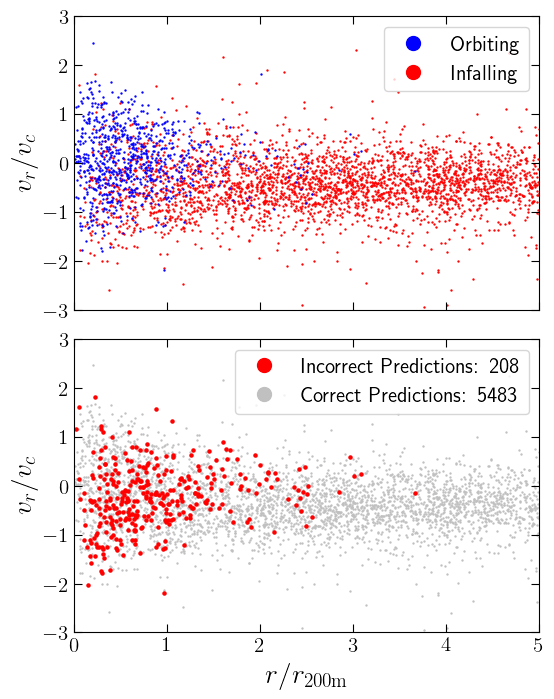

In [87]:
fig = plt.figure(figsize=(6,8))
gs = gridspec.GridSpec(2,1, hspace = 0.1)
ax1 = plt.subplot(gs[0])
ax0 = plt.subplot(gs[1])

data = results
data['r'] = np.sqrt(data[xyz[0]]**2+data[xyz[1]]**2+data[xyz[2]]**2)
data['vr'] = (data[xyz[3]]*data[xyz[0]] + data[xyz[4]]*data[xyz[1]] + data[xyz[5]]*data[xyz[2]])/data['r']
sample_data = data.sample(frac = 0.01)

ax1.scatter(sample_data['r'][sample_data[xyz[6]] == 1],sample_data['vr'][sample_data[xyz[6]] == 1],c='r',s=0.5)
ax1.scatter(sample_data['r'][sample_data[xyz[6]] == 0],sample_data['vr'][sample_data[xyz[6]] == 0],c='b',s=0.5)
ax1.set_ylim([-3,3])
ax1.set_xlim([0,5])
ax1.set_ylabel(r'$v_{r}/v_c$',fontsize=20)

ax0.scatter(sample_data['r'][sample_data[xyz[7]] == 1],sample_data['vr'][sample_data[xyz[7]] == 1],c='red',s=5, zorder = 1)
ax0.scatter(sample_data['r'][sample_data[xyz[7]] == 0],sample_data['vr'][sample_data[xyz[7]] == 0],c='silver',s=0.5, zorder = 0)
ax0.set_ylim([-3,3])
ax0.set_xlim([0,5])
ax0.set_ylabel(r'$v_r / v_c$', fontsize=20)
ax0.set_xlabel(r'$r/r_{\rm 200m}$',fontsize=20)

ax0.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax1.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax1.xaxis.set_ticklabels([])

legend_elements = [Line2D([0], [0], marker='o', color='blue', label='Orbiting',
                          markerfacecolor='blue', markersize=10, linestyle=''),
                   Line2D([0], [0], marker='o', color='red', label='Infalling',
                          markerfacecolor='red', markersize=10, linestyle='')]
ax1.legend(handles = legend_elements, fontsize = 15, loc = 'upper right')


legend_elements0 = [Line2D([0], [0], marker='o', color='red', label='Incorrect Predictions: 208',
                          markerfacecolor='red', markersize=10, linestyle=''),
                   Line2D([0], [0], marker='o', color='silver', label='Correct Predictions: 5483',
                          markerfacecolor='silver', markersize=10, linestyle='')]
ax0.legend(handles = legend_elements0, fontsize = 15, loc = 'upper right')